In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score


## Dataset size
We view the size of training set, dev set, entire test set, test subset, and the 3 splits (ID, near-OOD, far-OOD).

In [3]:
def dataset_counts(dataset: str) -> None:
    base_path = Path("../data") / dataset
    counts = {}
    for split in ("train", "dev", "test"):
        df = pd.read_json(base_path / f"{dataset}-{split}.jsonl", lines=True)
        counts[split] = len(df)

    df = pd.read_json(base_path / f"{dataset}-annotations.jsonl", lines=True)
    counts["test-full"] = len(df)

    df = pd.read_json(base_path / f"{dataset}-test.jsonl", lines=True)
    total = 0
    for split in ("in", "near-ood", "far-ood"):
        split_size = (df["labels"] == split).sum().item()
        total += split_size
        counts[f"test-subset-{split}"] = split_size

    counts["test-subset"] = total
    return counts


for dataset in ("nq", "webquestions", "triviaqa"):
    counts = dataset_counts(dataset)
    print(f"{dataset}: {counts}\n")

nq: {'train': 79168, 'dev': 8757, 'test': 1940, 'test-full': 3610, 'test-subset-in': 318, 'test-subset-near-ood': 315, 'test-subset-far-ood': 1307, 'test-subset': 1940}

webquestions: {'train': 2474, 'dev': 278, 'test': 1423, 'test-full': 2032, 'test-subset-in': 271, 'test-subset-near-ood': 299, 'test-subset-far-ood': 853, 'test-subset': 1423}

triviaqa: {'train': 78785, 'dev': 8837, 'test': 3948, 'test-full': 11313, 'test-subset-in': 336, 'test-subset-near-ood': 411, 'test-subset-far-ood': 3201, 'test-subset': 3948}



## AUROC scores

In [16]:
def make_split(test_df: pd.DataFrame, pos_classes: list[str], score_type: str) -> tuple:
    mask = test_df["labels"].isin(["in", *pos_classes])
    y_true = test_df.loc[mask, "labels"].isin(pos_classes)
    y_score = test_df.loc[mask, score_type]
    return y_true, y_score


def read_baselines(base: Path, suffix: str = "baselines.jsonl") -> pd.DataFrame:
    test_df = pd.read_json(base / suffix, lines=True)
    results = []

    for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
        split_name = "in vs " + " + ".join(split)
        for score_type in ("mean_sp", "min_sp"):
            y_true, y_score = make_split(test_df, split, score_type)
            auroc_val = roc_auc_score(y_true, y_score)
            results.append({
                "split": split_name,
                "score_type": score_type,
                "AUROC": f"{auroc_val:.3f}",
            })

    return pd.DataFrame(results)


def read_uq_sequence(base: Path) -> pd.DataFrame:
    results = []
    for model in ("mcdropout", "flipout"):
        for metric in ("f1", "bertscore"):
            results_path = base / f"{model}-large-{metric}.jsonl"
            if not results_path.exists():
                print(f"{model}-{metric} does not exist")
                continue

            test_df = pd.read_json(results_path, lines=True)
            for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
                split_name = "in vs " + " + ".join(split)
                y_true, y_score = make_split(test_df, split, metric)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{metric}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)


def read_uq_token(base: Path):
    results = []
    for model in ("mcdropout", "flipout"):
        results_path = base / f"{model}-large-token.jsonl"
        if not results_path.exists():
            print(f"{model}-large-token.jsonl does not exist")
            continue

        test_df = pd.read_json(results_path, lines=True)
        for split in (["far-ood"], ["near-ood"], ["far-ood", "near-ood"]):
            split_name = "in vs " + " + ".join(split)
            for score_type in ("mean_mi", "max_mi"):
                y_true, y_score = make_split(test_df, split, score_type)

                auroc_val = roc_auc_score(y_true, y_score)
                results.append({
                    "split": split_name,
                    "score_type": f"{model}-{score_type}",
                    "AUROC": f"{auroc_val:.3f}",
                })

    return pd.DataFrame(results)


def compute_aurocs(dataset: str) -> None:
    base = Path("../results")
    baseline_df = read_baselines(base / dataset)
    uq_sequence_df = read_uq_sequence(base / dataset)
    uq_token_df = read_uq_token(base / dataset)

    # combined_df = pd.concat([baseline_df, uq_sequence_df]).reset_index(drop=True)

    combined_df = pd.concat([baseline_df, uq_sequence_df, uq_token_df]).reset_index(drop=True)

    combined_df["AUROC"] = combined_df["AUROC"].astype(float)           # for sorting safely

    pivot_df = combined_df.pivot_table(index="score_type", columns="split", values="AUROC")
    pivot_df = pivot_df[["in vs near-ood", "in vs far-ood", "in vs far-ood + near-ood"]]
    pivot_df.columns = ["Near", "Far", "Combined"]
    print(f"RESULTS FOR {dataset}")
    print(pivot_df.to_string())

for split in ("webquestions", "nq"):
    compute_aurocs(split)
    print("\n\n")

flipout-large-token.jsonl does not exist
RESULTS FOR webquestions
                      Near    Far  Combined
score_type                                 
flipout-bertscore    0.662  0.740     0.720
flipout-f1           0.682  0.731     0.718
mcdropout-bertscore  0.629  0.739     0.710
mcdropout-f1         0.657  0.723     0.706
mcdropout-max_mi     0.670  0.746     0.726
mcdropout-mean_mi    0.675  0.781     0.753
mean_sp              0.664  0.690     0.683
min_sp               0.642  0.709     0.691



RESULTS FOR nq
                      Near    Far  Combined
score_type                                 
flipout-bertscore    0.705  0.803     0.784
flipout-f1           0.727  0.780     0.770
flipout-max_mi       0.530  0.611     0.595
flipout-mean_mi      0.535  0.612     0.598
mcdropout-bertscore  0.662  0.773     0.752
mcdropout-f1         0.723  0.771     0.761
mcdropout-max_mi     0.719  0.803     0.786
mcdropout-mean_mi    0.751  0.815     0.802
mean_sp              0.597  0.538   

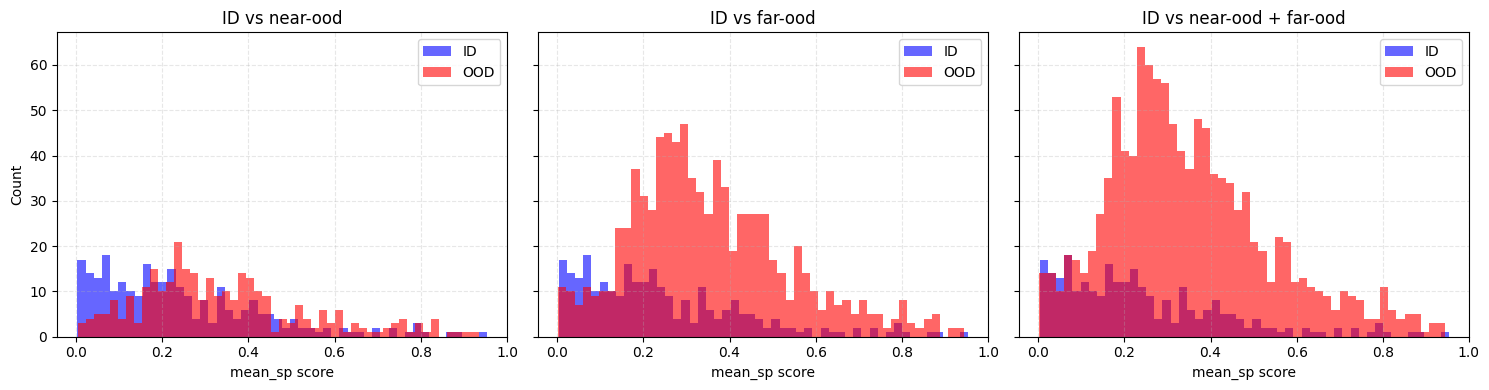

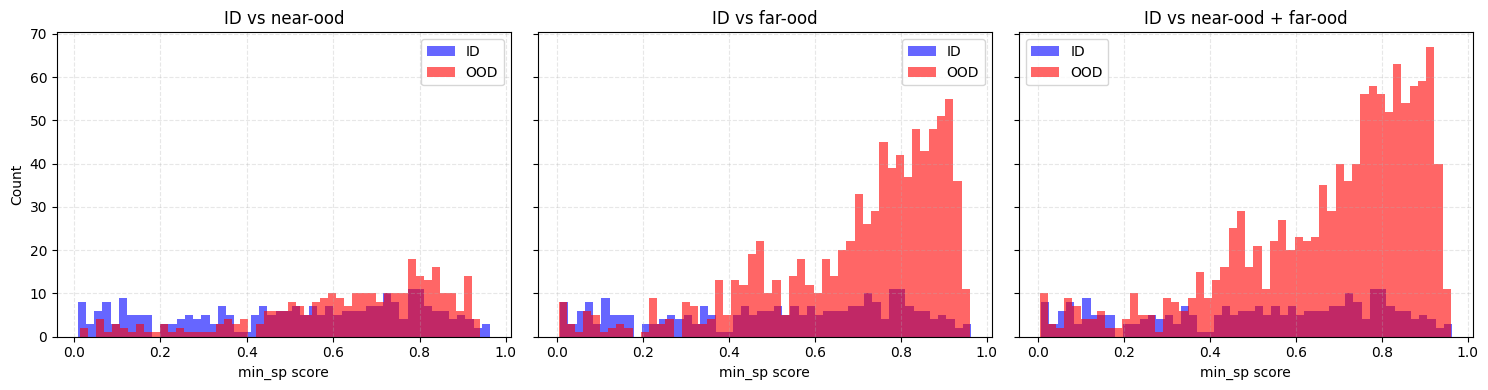

In [ ]:
def view_hist(dataset: str) -> None:
    base = Path("../results")
    suffix = "baselines.jsonl"
    df = pd.read_json(base / dataset / suffix, lines=True)

    for method in ("mean_sp", "min_sp"):
        _, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

        id_data = df[df["labels"] == "in"][method].to_numpy()
        splits = (("near-ood",), ("far-ood",), ("near-ood", "far-ood"))
        for idx, cols in enumerate(splits):
            ood_data = df[df["labels"].isin(cols)][method].to_numpy()
            ax[idx].hist(id_data, bins=50, alpha=0.6, color="blue", label="ID")
            ax[idx].hist(ood_data, bins=50, alpha=0.6, color="red", label="OOD")
            ax[idx].set_xlabel(f"{method} score")
            ax[idx].set_ylabel("Count" if idx == 0 else "")
            ax[idx].set_title(f"ID vs {' + '.join(cols)}")
            ax[idx].legend()
            ax[idx].grid(alpha=0.3, linestyle="--")

        plt.tight_layout()
        plt.show()

view_hist("webquestions")


Removed:
- ROC curves
- EM scores and performance (#correct) per split. using most common answer as hard prediction. including answer normalization.
